# Neutal network classification with pytorch

### 1. Make classification data and get it ready

In [ ]:
from sklearn.datasets import make_circles

In [ ]:
# Make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 examples of X:\n {X[:5]}")
print(f"First 5 examples of y:\n {y[:5]}")

First 5 examples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 examples of y:
 [1 1 1 1 0]


In [ ]:
# Make DataFrame of pandas
import pandas as pd
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "TARGET" : y
})

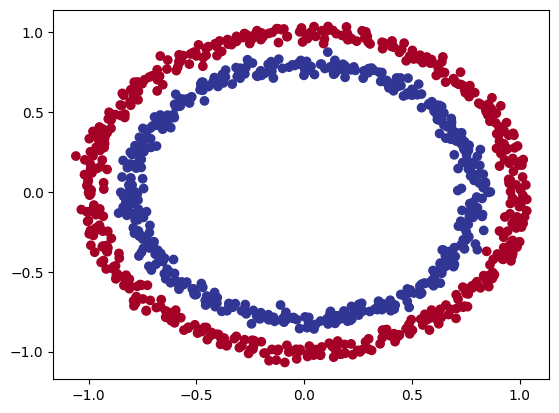

In [ ]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

### 1.1 Input and output shapes
One of the most common errors in deep learning is shape errors.

Mismatching the shapes of tensors and tensor operations with result in errors in your models.

We're going to see plenty of these throughout the course.

And there's no surefire way to making sure they won't happen, they will.

What you can do instead is continually familiarize yourself with the shape of the data you're working with.

I like referring to it as input and output shapes.

Ask yourself:

"What shapes are my inputs and what shapes are my outputs?"

Let's find out.

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits
We've investigated the input and output shapes of our data, now let's prepare it for being used with PyTorch and for modelling.

Specifically, we'll need to:

Turn our data into tensors (right now our data is in NumPy arrays and PyTorch prefers to work with PyTorch tensors).
Split our data into training and test sets (we'll train a model on the training set to learn the patterns between X and y and then evaluate those learned patterns on the test dataset).

In [ ]:
import torch
torch.__version__

'2.1.0+cu121'

In [ ]:
type(X)

numpy.ndarray

In [ ]:
# transforming from numpy array into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [ ]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model
Let's build a model to classify our blue and red dots.

To do so, we want to:

1. Setup device agonistic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing nn.Module)
3. Define a loss function and optimizer
4. Create a training and test loop

In [ ]:
# import torch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Now we've setup device agnostic code, let's create a model that:

1. Subclasses ``nn.Module`` (almost all models in PyTorch subclass ``nn.Module``)
2. Create 2 ``nn.Linear()`` layers that are capable of handling the shapes of our data
3. Defines a ``forward()`` method that outlines the forward pass (or forward computation) of the model
4. Instatiate an instance of our model class and send it to the target ``device``

In [ ]:
# build the model
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    # since the shape of our inpute data is 2, we will build 2 layers
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features ( hidden layer )
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and output a singe feature (same shape as y)

  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output


In [ ]:
model_0 = CircleModel().to(device)
model_0

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6296,  0.3204],
                      [ 0.4612, -0.3561],
                      [ 0.4025,  0.1957],
                      [-0.5114, -0.4812],
                      [-0.5420,  0.2329]], device='cuda:0')),
             ('0.bias',
              tensor([-0.1363, -0.3168, -0.5172,  0.4473,  0.0164], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.3920, -0.3404, -0.0406, -0.4086,  0.4218]], device='cuda:0')),
             ('1.bias', tensor([-0.0850], device='cuda:0'))])

In [ ]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[ 0.],
        [ 0.],
        [-0.],
        [ 0.],
        [-1.],
        [-0.],
        [ 0.],
        [-0.],
        [-0.],
        [ 0.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## 2.1 Setup loss function and optimizer
Which loss function or optimizer should you use?

Again... this is problem specific.

For example for regression you might want MAE or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how wrong your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

In [ ]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function build in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
 ## calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## 3. Train model
To train our model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)
#### 3.1 Going from raw logits -> prediction probabilities -> prediction labels
Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the ``argmax()``.

In [ ]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.1587],
        [ 0.3278],
        [-0.3913],
        [ 0.3150],
        [-0.5608]], device='cuda:0')

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5396],
        [0.5812],
        [0.4034],
        [0.5781],
        [0.3634]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:

* ``y_pred_probs`` >= 0.5, y=1 (class 1)
* ``y_pred_probs`` < 0.5, y=0 (class 0)

In [ ]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 0., 1., 0.], device='cuda:0')

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
torch.cuda.manual_seed(42)

## set the numbers of epochs
epochs = 100

# Put the training data into cuda
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

   ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_loss:.2f}%")


Epoch: 0 | Loss: 0.70934, Acc: 49.12% | Test loss: 0.72153, Test acc: 0.72%
Epoch: 10 | Loss: 0.70331, Acc: 49.75% | Test loss: 0.71483, Test acc: 0.71%
Epoch: 20 | Loss: 0.70056, Acc: 50.12% | Test loss: 0.71123, Test acc: 0.71%
Epoch: 30 | Loss: 0.69899, Acc: 50.62% | Test loss: 0.70887, Test acc: 0.71%
Epoch: 40 | Loss: 0.69794, Acc: 50.88% | Test loss: 0.70711, Test acc: 0.71%
Epoch: 50 | Loss: 0.69715, Acc: 50.88% | Test loss: 0.70572, Test acc: 0.71%
Epoch: 60 | Loss: 0.69654, Acc: 51.12% | Test loss: 0.70457, Test acc: 0.70%
Epoch: 70 | Loss: 0.69604, Acc: 51.38% | Test loss: 0.70360, Test acc: 0.70%
Epoch: 80 | Loss: 0.69563, Acc: 51.25% | Test loss: 0.70277, Test acc: 0.70%
Epoch: 90 | Loss: 0.69528, Acc: 51.12% | Test loss: 0.70206, Test acc: 0.70%


### 4. Make predictions and evaluate the model
From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

To do so, we're going to import a function called

To do so, we're going to import a function called ``plot_decision_boundary()``


In [ ]:
import requests
from pathlib import Path

# Download helpers functions from Learn PyTorch repo (if it's not downloaded)
if Path('helper_functions.py').is_file():
  print('helpers_functions.py already exists')
else:
  print('*** Downloading helpers_functions.py')
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

*** Downloading helpers_functions.py


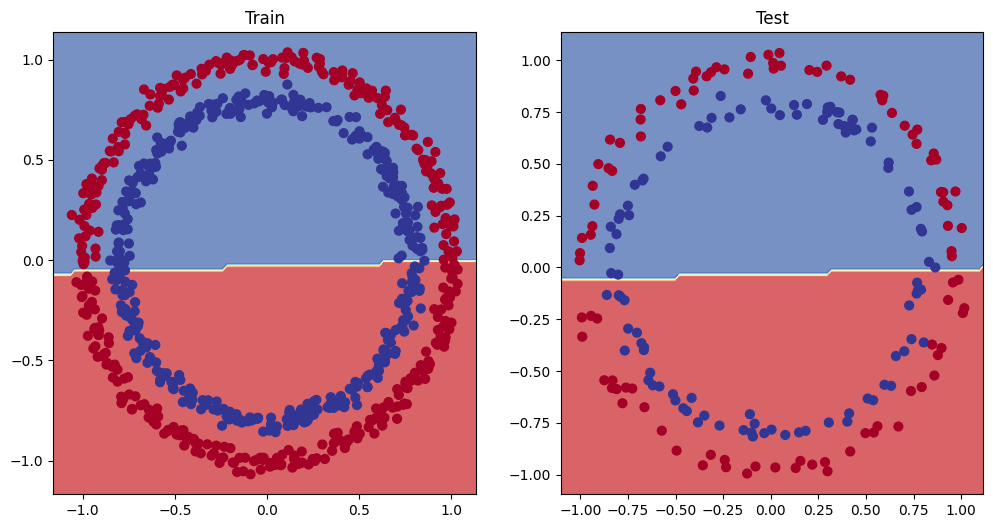

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)
* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function
These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred as hyperparameters.

Let's try and improve our model by:

* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

### 6.2 Building a model with non-linearity
* Linear = straight lines
* Non-linear = non-straight lines

Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

In [ ]:
## building model using Sequential
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=1),
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function build in

optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.0001)

In [ ]:
## calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [ ]:
torch.cuda.manual_seed(42)

## set the numbers of epochs
epochs = 100

# Put the training data into cuda
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

   ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_loss:.2f}%")


Epoch: 0 | Loss: 0.69345, Acc: 50.00% | Test loss: 0.69342, Test acc: 0.69%
Epoch: 10 | Loss: 0.68877, Acc: 77.38% | Test loss: 0.68975, Test acc: 0.69%
Epoch: 20 | Loss: 0.68521, Acc: 60.62% | Test loss: 0.68701, Test acc: 0.69%
Epoch: 30 | Loss: 0.68140, Acc: 59.25% | Test loss: 0.68396, Test acc: 0.68%
Epoch: 40 | Loss: 0.67688, Acc: 60.88% | Test loss: 0.68025, Test acc: 0.68%
Epoch: 50 | Loss: 0.67090, Acc: 66.62% | Test loss: 0.67520, Test acc: 0.68%
Epoch: 60 | Loss: 0.66336, Acc: 71.38% | Test loss: 0.66867, Test acc: 0.67%
Epoch: 70 | Loss: 0.65355, Acc: 79.62% | Test loss: 0.66016, Test acc: 0.66%
Epoch: 80 | Loss: 0.64106, Acc: 86.12% | Test loss: 0.64948, Test acc: 0.65%
Epoch: 90 | Loss: 0.62534, Acc: 91.62% | Test loss: 0.63581, Test acc: 0.64%


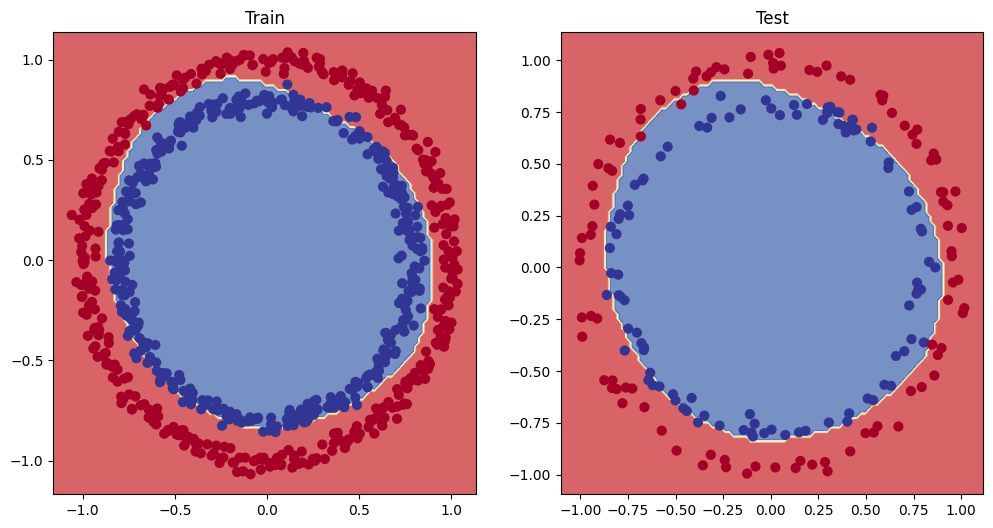

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 7. Puting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud or not fraud)
* Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)

## 7.1 Creating a toy multi-class dataset

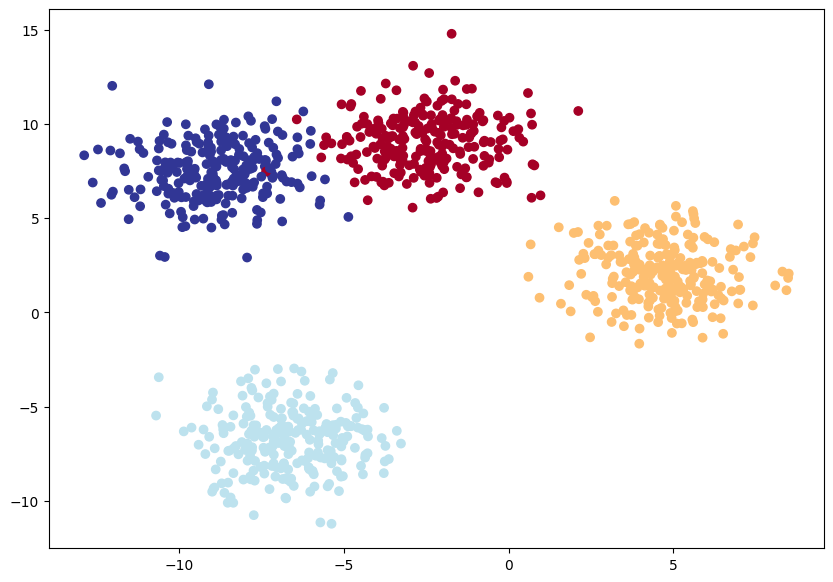

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 7.2 Building a multi-class classification model in PyTorch

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from torch import nn
import torch

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):

    """Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features= input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(
    input_features = 2,
    output_features = 4
).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 7.3 Create a loss function and an optimize for a multiclass label

In [ ]:
# Create a loss function for multi-class classification - loss function measures how wrong our model's predictions are
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1) # learning rate is a hyperparameter you can change

### 7.4 Getting prediction probabilities for a multi-class PyTorch model
In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to predicition probabilities and then to prediction labels.

Logits (raw output of the model) -> Pred probs (use ``torch.softmax``) -> Pred labels (take the argmax of the prediction probabilities)

In [ ]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[ 0.2414, -0.2901, -0.1012,  0.5614],
        [ 0.1068, -0.2985,  0.1402,  0.1419],
        [ 1.0566,  0.1219, -0.9693, -0.3507],
        [ 0.0050, -0.2037,  0.1157,  0.3784],
        [ 0.3727, -0.3357, -0.1328,  0.4888],
        [ 0.1714, -0.2663,  0.1050,  0.1054],
        [ 0.9787,  0.0980, -0.9262, -0.2478],
        [ 0.2527, -0.2945,  0.0130,  0.3642],
        [ 1.2617,  0.1665, -1.1181, -0.5295],
        [ 0.2887, -0.3069, -0.0337,  0.4064]], device='cuda:0')

In [ ]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.2414, -0.2901, -0.1012,  0.5614],
        [ 0.1068, -0.2985,  0.1402,  0.1419],
        [ 1.0566,  0.1219, -0.9693, -0.3507],
        [ 0.0050, -0.2037,  0.1157,  0.3784],
        [ 0.3727, -0.3357, -0.1328,  0.4888]], device='cuda:0')
tensor([[0.2721, 0.1599, 0.1932, 0.3748],
        [0.2676, 0.1785, 0.2767, 0.2772],
        [0.5652, 0.2219, 0.0745, 0.1384],
        [0.2282, 0.1852, 0.2550, 0.3316],
        [0.3107, 0.1530, 0.1874, 0.3489]], device='cuda:0')


In [ ]:
torch.sum(y_pred_probs[0])

tensor(1.0000, device='cuda:0')

In [ ]:
torch.argmax(y_pred_probs[0])

tensor(3, device='cuda:0')

In [ ]:
## Convert our model's predictions probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 3, 0, 3, 3, 0, 0, 3, 0, 3, 3, 3, 3, 3, 3, 2, 3, 0, 2, 0, 2, 3, 3, 0,
        0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 0, 0, 3, 2, 3, 3,
        3, 2, 3, 3, 3, 3, 0, 0, 3, 3, 0, 0, 0, 3, 0, 0, 0, 3, 3, 2, 3, 3, 3, 2,
        0, 2, 0, 0, 0, 2, 2, 3, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 0, 0,
        3, 3, 2, 0, 3, 3, 2, 3, 0, 2, 3, 2, 2, 0, 3, 3, 3, 0, 0, 2, 3, 3, 3, 0,
        0, 3, 3, 3, 0, 3, 3, 3, 0, 0, 3, 0, 2, 0, 3, 0, 3, 3, 3, 3, 3, 3, 0, 0,
        0, 0, 3, 0, 2, 0, 0, 3, 0, 0, 3, 3, 2, 2, 0, 3, 0, 3, 0, 0, 3, 0, 0, 3,
        0, 0, 0, 3, 2, 3, 3, 3, 3, 3, 0, 3, 3, 0, 0, 3, 0, 0, 3, 3, 0, 0, 3, 2,
        3, 0, 0, 3, 0, 3, 0, 3], device='cuda:0')

In [ ]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 7.5 Creating a training loop and testing loop for a multi-class Pytorch modem